# Characterize the population of remnant black holes

In [56]:
import numpy as np
import h5py
%matplotlib inline
from matplotlib import pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from scipy.interpolate import interp1d
import matplotlib 
matplotlib.rcParams['text.usetex'] = True
%config InlineBackend.figure_format='retina'
from scipy.stats import gaussian_kde

### Define population model samplers

In [2]:
class ModelB:
    def __init__(self,alpha_m=2,beta_q=1,log10_rate=1e2,m_max=50,m_min=5):
        self.hyperparam_names = ['alpha_m', 'beta_q', 'log10_rate', 'm_max', 'm_min']
        self.alpha_m = alpha_m
        self.beta_q = beta_q
        self.log10_rate = log10_rate
        self.m_max = m_max
        self.m_min = m_min     
        
    def set_hyperparams(self,hyperparams):
        self.alpha_m, self.beta_q,self.log10_rate,self.m_max,self.m_min = hyperparams
        
    def pdf(self,params):
        params = m1,m2
        k = (1.-self.alpha_m) / (self.m_max**(1.-self.alpha_m)-self.m_min**(1.-self.alpha_m))
        Cm1 = (self.beta_q+1.) / (m1**(self.beta_q+1.) - self.m_min**(self.beta_q+1.))
        return k * Cm1 * m1**(-self.alpha_m) * m2**self.beta_q
    
    def inv_cdf_m1(self,CDF):
        return ((self.m_max**(1.-self.alpha_m) - self.m_min**(1.-self.alpha_m))*CDF + self.m_min**(1.-self.alpha_m))**(1./(1.-self.alpha_m))
        
    def inv_cdf_q(self,CDF):
        return CDF**(1./(self.beta_q+1.))
    
    def sample(self,n=1):
        """return m1 and q samples using inverse CDF sampling"""
        return self.inv_cdf_m1(np.random.uniform(size=n)),self.inv_cdf_q(np.random.uniform(size=n))

    


### Define Final State Mapping

In [3]:
sxa1 = 0.187
sya1 = 0.028
sz0 = 0.686
sza1 = 0.15
w = 0.05
k = 0.008
c1 = 0.762
c3 = 0.632
m0 = 0.9515
ma1 = -0.013


def g(q,c):
    return ((c+1.)**2)/((c+q)**2)

def eta(q): return q/((1.+q)**2)

def m_final_frac(s1,s2,q):
    return 1. + (m0 - 1.)*4.*eta(q) + (ma1*16.*eta(q)**2)*(s1[:,2]+s2[:,2])


def g(q,c):
    return ((c+1.)**2)/((c+q)**2)

def eta(q): return q/((1.+q)**2)

def sx_final(s1,s2,q):
    return (
        sxa1 * (g(q,c1)*s1[:,0] + g(1./q,c1)*s2[:,0]) -
        sya1*4.*eta(q)*(s1[:,1]+s2[:,1])
    )

def sy_final(s1,s2,q):
    return (
        sya1*4.*eta(q)*(s1[:,0]+s2[:,0]) +
        sxa1*(g(q,c1)*s1[:,1] + g(1./q,c1)*s2[:,1])
    )

def sz_final(s1,s2,q):
    term1 = sz0 * (4*w*eta(q) + 16.*(1.-w)*eta(q)**2)
    term2 = sza1*(g(q,c3)*s1[:,2] + g(1./q,c3)*s2[:,2])
    term3 = (
        (16.*k*eta(q)**2) *
        ((s1[:,0]+s2[:,0])**2 + (s1[:,1]+s2[:,1])**2 - (s1[:,2]+s2[:,2])**2)
    )
    return term1 + term2 + term3

def s_final(s1,s2,q):
    """
    Compute the final black hole spin from two merging blakc holes with
    spins s1 and s1 (each with x,y,z components) and mass ratio q.  Here,
    equations 5, 6, 8, and 9 from Tichy and Marronetti (2008) [0807.2985]
    are used.

    Parameters
    ----------
    s1: array, shape = (nmergers,3)
        ndarray with 3d spins for each m1 BH
    s2: array, shape = (nmergers,3)
        ndarray with 3d spins for each m2 BH
    q: array
        mass ratios

    Returns
    -------
    s_final: float
        The final BH spin
    """
    return np.array([
        sx_final(s1,s2,q),
        sy_final(s1,s2,q),
        sz_final(s1,s2,q),
    ]).T

def spin_mags(spins):
    return np.sqrt(np.sum(np.square(spins),axis=1))

### Get population predictive distributions
for each hyperposterior sample, draw a few (m1, q) samples based on the hyperposterior sample

In [4]:
model_name = 'model_b'
model = ModelB()
samples_per_hypsample = 10
with h5py.File('figure_data/corner_AB.h5') as f:
    hyperparams = []
    dtype = []
    for hyperparam_name in model.hyperparam_names:
        hyperparams.append(f[model_name][hyperparam_name][...])
        dtype.append((hyperparam_name,float))
    hyperparams = np.array(list(zip(*hyperparams)),dtype=dtype)
    m1q_out = np.empty((2,samples_per_hypsample*len(hyperparams)),dtype=float)
    for hi,hyp in enumerate(hyperparams):
        model.set_hyperparams(hyp)
        lidx = hi*samples_per_hypsample
        uidx = hi*samples_per_hypsample+samples_per_hypsample
        m1q_out[:,lidx:uidx] = model.sample(samples_per_hypsample)


/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide
/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in square
/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/Users/Zoheyr/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


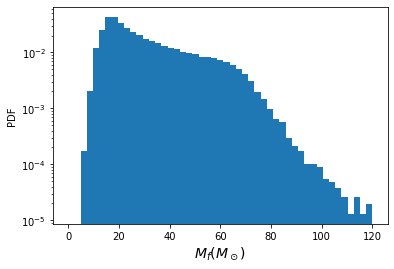

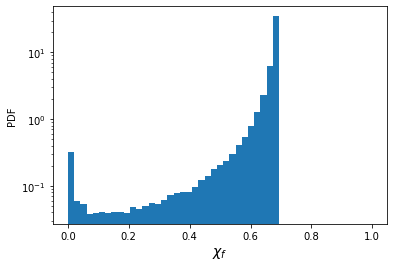

In [43]:
mtot = (1.+m1q_out[1])*m1q_out[0]
s1,s2 = np.zeros((len(mtot),3),dtype=float),np.zeros((len(mtot),3),dtype=float)
mf = mtot*m_final_frac(s1,s2,m1q_out[1])
s_fin = spin_mags(s_final(s1,s2,m1q_out[1]))
plt.hist(mf,bins=np.linspace(0,120,50),density=True);
plt.xlabel(r'$M_f (M_\odot)$',fontsize=14)
plt.ylabel('PDF')
plt.yscale('log')
plt.figure()
plt.hist(s_fin,np.linspace(0,1,50),density=True)
plt.xlabel(r'$\chi_f$',fontsize=14)
plt.ylabel('PDF')
plt.yscale('log')


### Now integrate the rate over time. 
We'll assume the rate follows the cosmic star formation rate, but with some fiducial delay time distribution.  We'll use the star formation rate from [Madau and Fragos](https://arxiv.org/pdf/1606.07887.pdf):
$$\psi(z) = 0.01 \frac{(1+z)^{2.6}}{1+[(1+z)/3.2]^{6.2}} \textrm{M}_\odot \textrm{yr}^{-1}\textrm{Mpc}^{-3}$$
For the delay time distribution, we'll assume:
$$p(t_d) \propto t_d^{-1}\ \textrm{if}\ t_d>10\ \textrm{Myr, else}\ 0$$
The merger rate over cosmic time is:
$$R(t) = A \int_0^{t} p(t-t')\psi(t') dt'$$
And we know that $R(t_h) = R_0$ where $R_0$ is the present-day rate inferred by the LVC, so:
$$A = \frac{R_0}{\int_0^{t_h} p(t-t')\psi(t') dt'}$$
The current number density of remnants is:
$$n = \int_0^{t_h} R(t) dt = R_0\frac{\int_0^{t_h} \int_0^{t} p(t-t')\psi(t') dt'}{\int_0^{t_h} p(t-t')\psi(t') dt'}$$

In [38]:
class RateCalculator(FlatLambdaCDM):
    def __init__(self,H0=70., Om0=0.3,alpha=1,td_min=1e7):
        self.dist_unit = u.megaparsec
        self.time_unit = u.year
        self.alpha= alpha
        self.td_min = td_min #minimum delay time
        super().__init__(H0,Om0)
        self.z_min,self.z_max = 0,15
        self.zgrid = np.linspace(self.z_min,self.z_max,1000)
        self.t_of_zgrid = self.hubble_time.to_value(self.time_unit) - self.lookback_time(self.zgrid).to_value(self.time_unit)
        self.t_min = np.amin(self.t_of_zgrid) # age of universe at z_max
        self.t_of_z = interp1d(self.zgrid,self.t_of_zgrid)
        self.z_of_t = interp1d(self.t_of_zgrid,self.zgrid)
        self.R_norm = self.R_of_t(self.hubble_time.to_value(self.time_unit))
        
        
    def sfr_of_t(self,t):
        """Return star formation rate in units of solar masses per year per cubic Mpc"""
        z = self.z_of_t(t) 
        return self.sfr_of_z(z)
        
    def sfr_of_z(self,z):
        return 0.01*(1.+z)**2.6 / (1.+((1.+z)/3.2)**6.2)

    def p_delay_time(self,t):
        """un-normalized probability of a given delay time for a 
        delay time distribution t_d^-alpha where t_d > t_min, else 0
        """
        return np.array([ti**(-self.alpha) if ti>self.td_min else 0 for ti in t])
    
    def R_of_t(self,t):
        sel = self.t_of_zgrid <= t
        # negative sign below to deal with t_of_zgrid going from high to low
        return -np.trapz(self.sfr_of_t(self.t_of_zgrid[sel])*self.p_delay_time(t-self.t_of_zgrid[sel]),self.t_of_zgrid[sel])
    
    def number_density(self,t=None,present_rate=1e-7):
        if t is None:
            t = self.hubble_time.to_value(self.time_unit)
        integrand_vals = np.array(list(map(self.R_of_t,self.t_of_zgrid)))
        sel = self.t_of_zgrid <= t
        return -present_rate*np.trapz(integrand_vals[sel],self.t_of_zgrid[sel])/self.R_norm
        

In [42]:
rate_calc = RateCalculator()
number_density = rate_calc.number_density()
print(f'the current number density of remnant black holes is {number_density} per cubic megaparsec')

the current number density of remnant black holes is 3063.7314139566956 per cubic megaparsec


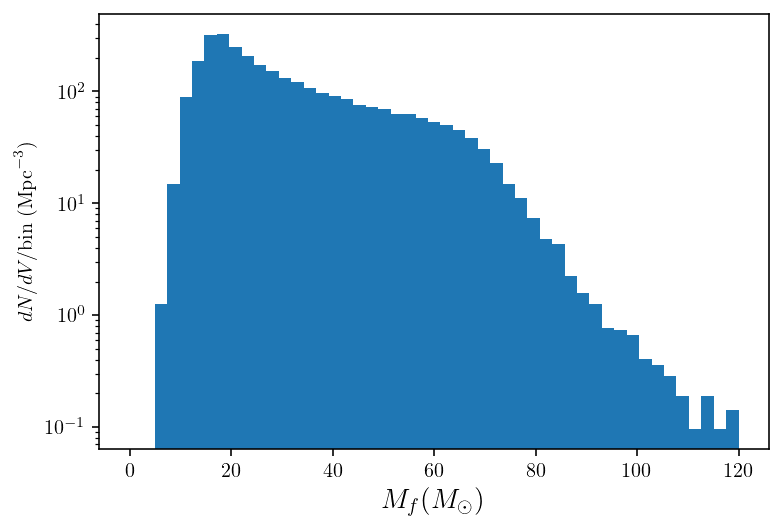

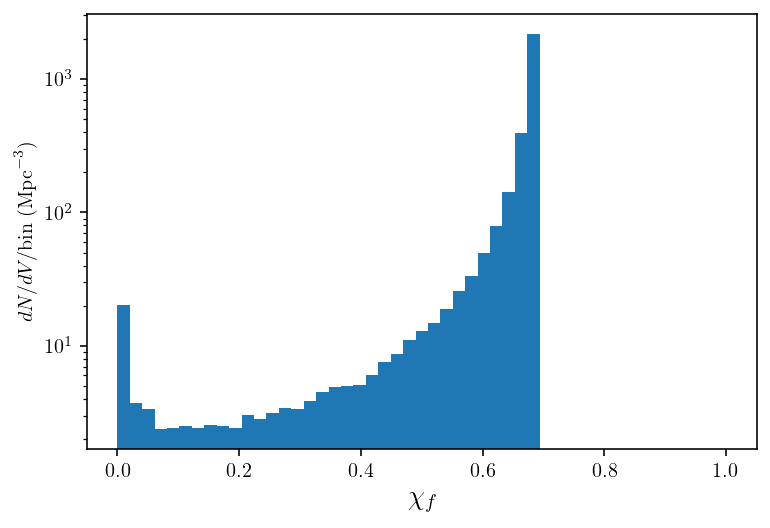

In [55]:
weights = number_density*np.ones_like(mf)/len(mf)
plt.hist(mf,bins=np.linspace(0,120,50),weights = weights);
plt.xlabel(r'$M_f (M_\odot)$',fontsize=14)
plt.ylabel(r'$dN/dV/ \textrm{bin}\ (\textrm{Mpc}^{-3})$')
plt.yscale('log')
plt.figure()
plt.hist(s_fin,np.linspace(0,1,50),weights=weights)
plt.xlabel(r'$\chi_f$',fontsize=14)
plt.ylabel(r'$dN/dV/ \textrm{bin}\ (\textrm{Mpc}^{-3})$')
plt.yscale('log')

### Incorporate the overall rate from the samples
In the above, I entered a fiducial present day rate of $1\times10^{-7}\ \textrm{yr}^{-1}\ \textrm{Mpc}^{-3}$.  Let's now fully self consistently draw a prior curve for every hyperparameter sample:

In [80]:
model_name = 'model_b'
model = ModelB()
use_n_hypersamples = 200
samples_per_hypsample = 1000

#fig,ax = plt.subplots(1,2)
mgrid = np.linspace(0,120,100)
chigrid = np.linspace(0,1,100)

def get_mf_sf_pdf(hyp):
    model = ModelB(*hyp)
    num_dens = rate_calc.number_density(present_rate=10**hyp['log10_rate']*1e-9)
    m1samp, qsamp = model.sample(samples_per_hypsample)
    mtot = (1.+qsamp)*m1samp
    s1,s2 = np.zeros((len(mtot),3),dtype=float),np.zeros((len(mtot),3),dtype=float)
    mf = mtot*m_final_frac(s1,s2,qsamp)
    s_fin = spin_mags(s_final(s1,s2,qsamp))
    p_mf = num_dens*gaussian_kde(mf)(mgrid)
    p_sf = num_dens*gaussian_kde(s_fin)(chigrid)
    return p_mf,p_sf

with h5py.File('figure_data/corner_AB.h5') as f:
    hyperparams = []
    dtype = []
    for hyperparam_name in model.hyperparam_names:
        hyperparams.append(f[model_name][hyperparam_name][...])
        dtype.append((hyperparam_name,float))
    hyperparams = np.array(list(zip(*hyperparams)),dtype=dtype)
    hyperparams = np.random.choice(hyperparams,size=use_n_hypersamples,replace=False)
    out = np.array([get_mf_sf_pdf(hyp) for hyp in hyperparams])
    np.save('Mf_sf_pdfs.npy',out)     

Text(0, 0.5, '$\\frac{dN}{d\\chi_f dV} (\\textrm{Mpc}^{-3})$')

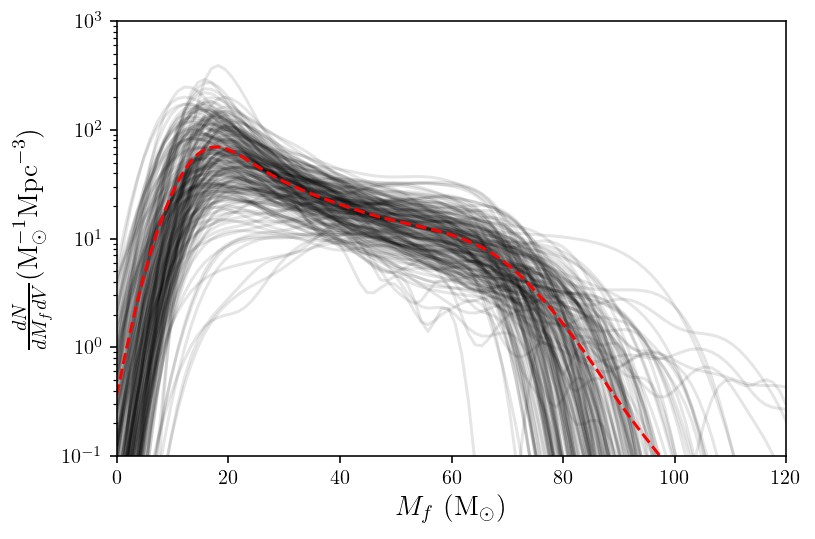

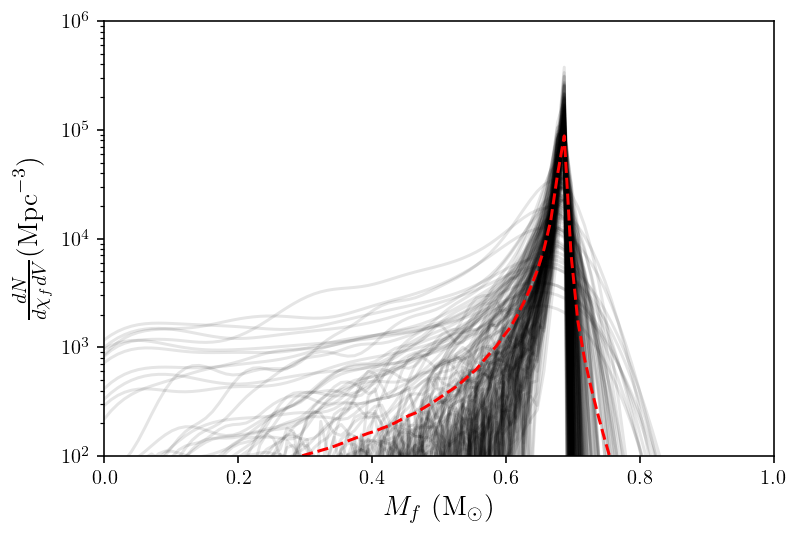

In [98]:
data = np.load('Mf_sf_pdfs.npy')
plt.plot(mgrid,data[:,0,:].T,alpha=0.1,color='k')
plt.plot(mgrid,(data[:,0,:].T).mean(axis=1),color='r',ls='--')
plt.ylim(1e-1,1e3)
plt.yscale('log')
plt.xlim([0,120])
plt.xlabel(r'$M_f\ (\textrm{M}_\odot)$',fontsize=14)
plt.ylabel(r'$\frac{dN}{dM_f dV} (\textrm{M}_\odot^{-1}\textrm{Mpc}^{-3})$',fontsize=14)
plt.figure()
plt.plot(chigrid,data[:,1,:].T,alpha=0.1,color='k')
plt.plot(chigrid,(data[:,1,:].T).mean(axis=1),color='r',ls='--')
#plt.ylim(1e-1,1e3)
plt.yscale('log')
plt.ylim([1e2,1e6])
plt.xlim([0,1])
plt.xlabel(r'$M_f\ (\textrm{M}_\odot)$',fontsize=14)
plt.ylabel(r'$\frac{dN}{d\chi_f dV} (\textrm{Mpc}^{-3})$',fontsize=14)